In [1]:
from keras.models   import Model, load_model, model_from_json
from keras.layers   import Input, Dense, Dropout
from keras.datasets import mnist

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection   import train_test_split

import h5py

import numpy  as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image 

%matplotlib inline

Using TensorFlow backend.
/mnt/gpfs/Users/chenhe/bin/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Load data and model

In [2]:
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = mnist.load_data()

x_train = np.reshape( 
    (x_train_orig.astype('float32') / 255.), 
    (len(x_train_orig), x_train_orig.shape[1], x_train_orig.shape[2], 1) 
)

x_test  = np.reshape( 
    (x_test_orig.astype('float32')  / 255.), 
    (len(x_test_orig),  x_test_orig.shape[1],  x_test_orig.shape[2],  1) 
)

# y_train = OneHotEncoder(sparse=False,categories='auto').fit_transform(y_train_orig.reshape(-1, 1))
# y_test  = OneHotEncoder(sparse=False,categories='auto').fit_transform(y_test_orig.reshape(-1, 1))

In [3]:
f1 = h5py.File("train_signs.h5", "r")
f2 = h5py.File("test_signs.h5",  "r")

# Loading the data (signs)
X_train_orig = np.array(f1['train_set_x'])
Y_train_orig = np.array(f1['train_set_y'])
X_test_orig  = np.array(f2['test_set_x'])
Y_test_orig  = np.array(f2['test_set_y'])

X_train = (X_train_orig / 255).astype('float32')
X_test  = (X_test_orig  / 255).astype('float32')

test_datagen  = ImageDataGenerator( rescale=1./255, )
train_datagen = ImageDataGenerator( rescale=1./255,
    width_shift_range  = 0.15,
    height_shift_range = 0.15,
    shear_range        = 0.3,
    zoom_range         = 0.1,
    rotation_range     = 30,
    horizontal_flip    = True,
    vertical_flip      = False,
    fill_mode          = 'nearest',
)

train_datagen.fit(X_train_orig)
test_datagen.fit(X_test_orig)

# Y_train = OneHotEncoder(sparse=False,categories='auto').fit_transform(Y_train_orig.reshape(-1, 1))
# Y_test  = OneHotEncoder(sparse=False,categories='auto').fit_transform(Y_test_orig.reshape(-1, 1))

In [4]:
signs_autoencoder = load_model('signs_autoencoder.h5', compile=False)
# signs_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
# signs_autoencoder.summary()

signs_encoder = signs_autoencoder.layers[1]
signs_decoder = signs_autoencoder.layers[2]

In [5]:
mnist_autoencoder = load_model('mnist_dAE.h5')
# mnist_autoencoder.summary()
mnist_encoder = mnist_autoencoder.layers[1]
mnist_decoder = mnist_autoencoder.layers[2]

In [6]:
# decoded_imgs = signs_autoencoder.predict(X_test)

# n = 10  # how many digits we will display
# plt.figure(figsize=(20, 4))
# for i in range(n):
#     # display original
#     ax = plt.subplot(2, n, i + 1)
#     plt.imshow(X_test[i])
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

#     # display reconstruction
#     ax = plt.subplot(2, n, i + 1 + n)
#     plt.imshow(decoded_imgs[i])
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# plt.show()

## Link data

In [7]:
link_data_in  = np.array([])
link_data_out = np.array([])

link_data_in.shape  = (0,512)
link_data_out.shape = (0,32)

for n in range(0,6):
    signs_idx = np.where(Y_train_orig == n)[0]
    mnist_idx = np.where(y_train_orig == n)[0]

    n_signs = int(signs_idx.shape[0])
    n_times = int(mnist_idx.shape[0]/n_signs)
    n_total = n_times*n_signs

    data_iter = train_datagen.flow( X_train_orig[signs_idx], batch_size=n_signs, shuffle=False)

    signs_aug = np.array([])
    signs_aug.shape = (0,64,64,3)
    for _ in range( n_times ):
        signs_aug = np.vstack( (signs_aug, data_iter.next()) )

    signs_latent = signs_encoder.predict(signs_aug)
    mnist_latent = mnist_encoder.predict(x_train[mnist_idx[:n_total]])
    
    link_data_in  = np.vstack( (link_data_in,  signs_latent) )
    link_data_out = np.vstack( (link_data_out, mnist_latent) )
    
# h5f = h5py.File('link_data_in.h5', 'w')
# h5f.create_dataset('link_data_in',  data=link_data_in)
# h5f.close()

# h5f = h5py.File('link_data_out.h5', 'w')
# h5f.create_dataset('link_data_out', data=link_data_out)
# h5f.close()

In [8]:
# test_data_in  = np.array([])
# test_data_out = np.array([])

# test_data_in.shape  = (0,512)
# test_data_out.shape = (0,32)

# for n in range(0,6):
#     signs_idx = np.where(Y_test_orig == n)[0]
#     mnist_idx = np.where(y_test_orig == n)[0]

#     n_signs = int(signs_idx.shape[0])
#     n_times = int(mnist_idx.shape[0]/n_signs)
#     n_total = n_times*n_signs

#     data_iter = test_datagen.flow( X_test_orig[signs_idx], batch_size=n_signs, shuffle=False)

#     signs_aug = np.array([])
#     signs_aug.shape = (0,64,64,3)
#     for _ in range( n_times ):
#         signs_aug = np.vstack( (signs_aug, data_iter.next()) )

#     signs_latent = signs_encoder.predict(signs_aug)
#     mnist_latent = mnist_encoder.predict(x_test[mnist_idx[:n_total]])
    
#     test_data_in  = np.vstack( (test_data_in,  signs_latent) )
#     test_data_out = np.vstack( (test_data_out, mnist_latent) )

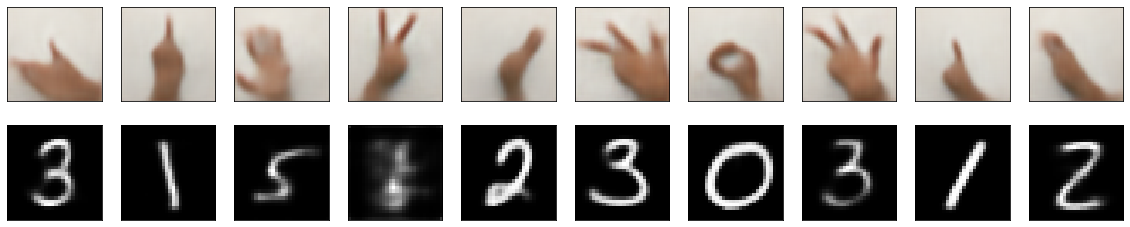

In [9]:
idx = np.random.choice(link_data_in.shape[0],10)
decoded_imgs_in  = signs_decoder.predict(link_data_in[idx])
decoded_imgs_out = mnist_decoder.predict(link_data_out[idx])

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(decoded_imgs_in[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_out[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Build link model

In [10]:
signs_Latent = Input(name='SIGNS_Latent', shape=(signs_encoder.outputs[0].shape[1].value,))
x = Dense(256, activation='relu', name='Link-1'   )(signs_Latent)
x = Dropout(rate=0.3,             name='Dropout-2')(x)
x = Dense(128, activation='relu', name='Link-3'   )(x)
x = Dropout(rate=0.2,             name='Dropout-4')(x)
x = Dense(32,  activation='relu', name='Link-5'   )(x)
mnist_Latent = x

In [11]:
signs_to_mnist_linker = Model(
    inputs=signs_Latent,
    outputs=mnist_Latent, 
    name='S_to_M_Linker'
)
signs_to_mnist_linker.compile(optimizer='adadelta', loss='mse')

In [12]:
in_train, in_test, out_train, out_test = train_test_split(link_data_in, link_data_out, test_size=0.2)

history = signs_to_mnist_linker.fit(
#     link_data_in, link_data_out,
    in_train, out_train,
    epochs=20,
    batch_size=32,
    shuffle=True,
    verbose=2,
#     validation_split=0.2,
    validation_data=(in_test,out_test)
);

Train on 28512 samples, validate on 7128 samples
Epoch 1/20
 - 3s - loss: 0.3533 - val_loss: 0.2973
Epoch 2/20
 - 2s - loss: 0.2941 - val_loss: 0.2879
Epoch 3/20
 - 2s - loss: 0.2854 - val_loss: 0.2823
Epoch 4/20
 - 2s - loss: 0.2805 - val_loss: 0.2831
Epoch 5/20
 - 2s - loss: 0.2778 - val_loss: 0.2795
Epoch 6/20
 - 2s - loss: 0.2761 - val_loss: 0.2789
Epoch 7/20
 - 2s - loss: 0.2748 - val_loss: 0.2795
Epoch 8/20
 - 2s - loss: 0.2739 - val_loss: 0.2784
Epoch 9/20
 - 2s - loss: 0.2723 - val_loss: 0.2781
Epoch 10/20
 - 2s - loss: 0.2716 - val_loss: 0.2782
Epoch 11/20
 - 2s - loss: 0.2710 - val_loss: 0.2781
Epoch 12/20
 - 2s - loss: 0.2700 - val_loss: 0.2773
Epoch 13/20
 - 3s - loss: 0.2697 - val_loss: 0.2781
Epoch 14/20
 - 2s - loss: 0.2684 - val_loss: 0.2776
Epoch 15/20
 - 2s - loss: 0.2683 - val_loss: 0.2773
Epoch 16/20
 - 2s - loss: 0.2677 - val_loss: 0.2776
Epoch 17/20
 - 2s - loss: 0.2670 - val_loss: 0.2804
Epoch 18/20
 - 2s - loss: 0.2662 - val_loss: 0.2772
Epoch 19/20
 - 2s - loss

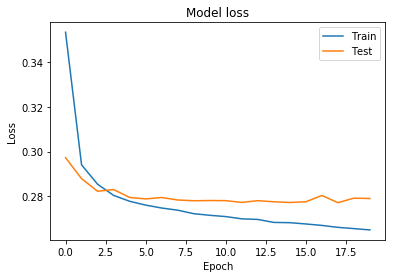

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [14]:
signs_to_mnist = Model(
    inputs = signs_encoder.inputs,
    outputs = mnist_decoder( signs_to_mnist_linker(signs_encoder(signs_encoder.inputs)) ),
    name='signs_to_mnist'
)

# signs_to_mnist.summary()

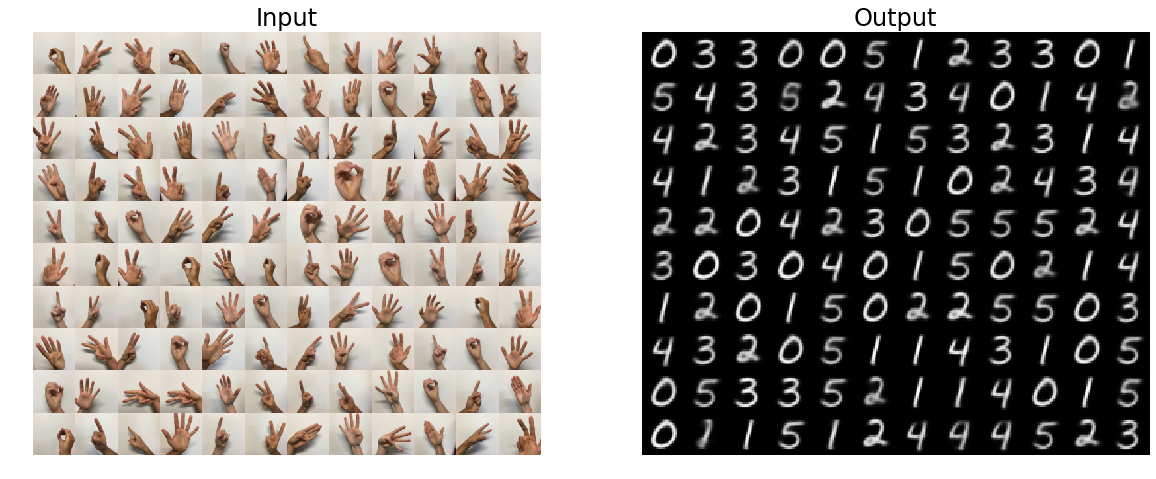

In [15]:
plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
rows, cols = 10, 12
num = rows * cols

imgs = X_test.reshape((rows, cols, 64, 64, 3))
imgs = np.vstack(np.split(imgs, cols, axis=1))
imgs = imgs.reshape((rows, -1, 64, 64, 3))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.axis('off')
plt.title('Input', fontsize=24)
plt.imshow(imgs)

plt.subplot(1,2,2)


rows, cols = 10, 12
num = rows * cols

imgs = signs_to_mnist.predict(X_test).reshape((rows, cols, 28, 28))
imgs = np.vstack(np.split(imgs, cols, axis=1))
imgs = imgs.reshape((rows, -1, 28, 28))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.axis('off')
plt.gray()
plt.title('Output', fontsize=24)
plt.imshow(imgs,)

plt.show()